## Example: Benchmarking a Model

This section demonstrates how to benchmark a model's embedding using czbenchmarks. 

### Step 1: Setup and Imports

In [13]:
# Create isolated virtual environment for scVI and czbenchmarks (run once)
# uncomment below code if you need to create a new virtual environment
# !python3 -m venv .venv_scvi

# # Install model required packages
# !.venv_scvi/bin/python -m pip install --upgrade pip
# !.venv_scvi/bin/python -m pip install ipykernel numpy pandas scvi-tools tabulate matplotlib seaborn

# # Register the new environment as a Jupyter kernel (if not already registered)
# !.venv_scvi/bin/python -m ipykernel install --user --name venv_scvi --display-name "Python (.venv_scvi)"

# print("Virtual environment '.venv_scvi' created, dependencies installed, and kernel registered.")


In [14]:
import logging
import sys
from czbenchmarks.datasets import load_dataset
from czbenchmarks.datasets.single_cell_labeled import SingleCellLabeledDataset
from czbenchmarks.tasks import (
    ClusteringTask,
    EmbeddingTask,
    MetadataLabelPredictionTask,
)
from czbenchmarks.tasks.clustering import ClusteringTaskInput
from czbenchmarks.tasks.embedding import EmbeddingTaskInput
from czbenchmarks.tasks.label_prediction import MetadataLabelPredictionTaskInput

# Model specific imports
import scvi  # other imports can be used as required by model
import functools

# --- Visualization Imports ---
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

# Set up basic logging to see the library's output
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

### Step 2: Load a Dataset

Load the pre-configured `tsv2_prostate` dataset. The library handles automatic download, caching, and loading as a `SingleCellLabeledDataset` for streamlined reuse.

**Loaded dataset provides:**
- `dataset.adata`: AnnData object with gene expression data.
- `dataset.labels`: pandas Series of cell type labels.

In [15]:
# The 'dataset' object is a validated AnnData wrapper, ensuring efficient downstream processing.
dataset: SingleCellLabeledDataset = load_dataset("tsv2_prostate")

INFO:czbenchmarks.file_utils:File already exists in cache: /Users/sgupta/.cz-benchmarks/datasets/homo_sapiens_10df7690-6d10-4029-a47e-0f071bb2df83_Prostate_v2_curated.h5ad
INFO:czbenchmarks.datasets.single_cell:Loading dataset from /Users/sgupta/.cz-benchmarks/datasets/homo_sapiens_10df7690-6d10-4029-a47e-0f071bb2df83_Prostate_v2_curated.h5ad


### Step 3: Run Model Inference and Get Output
Use a pre-trained scVI model to generate cell embeddings for evaluation within the benchmarking framework.

In [16]:
model_weights_dir = "/Users/sgupta/.cz-benchmarks/models"
required_obs_keys = ["dataset_id", "assay", "suspension_type", "donor_id"]

adata = dataset.adata.copy()

batch_keys = required_obs_keys
adata.obs["batch"] = functools.reduce(
    lambda a, b: a + b, [adata.obs[c].astype(str) for c in batch_keys]
)
# Use the scvi-tools API to map our dataset to the reference model
scvi.model.SCVI.prepare_query_anndata(adata, model_weights_dir)
scvi_model = scvi.model.SCVI.load_query_data(adata, model_weights_dir)
scvi_model.is_trained = True  # Ensure the model is marked as trained

# Now, generate the latent representation (the embedding)
scvi_embedding = scvi_model.get_latent_representation()
model_output = scvi_embedding

print(f"Generated scVI embedding with shape: {scvi_embedding.shape}")

INFO     File /Users/sgupta/.cz-benchmarks/models/model.pt already downloaded                                      
INFO     Found 44.05% reference vars in query data.                                                                


/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/scvi/model/base/_archesmixin.py:299: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  return _pad_and_sort_query_anndata(adata, var_names, inplace)


INFO     File /Users/sgupta/.cz-benchmarks/models/model.pt already downloaded                                      


/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/scvi/model/base/_archesmixin.py:105: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


Generated scVI embedding with shape: (2044, 50)


#### Optional: Fine-Tune the Model

Fine-tuning adjusts the pre-trained model to your dataset. Use a small number of epochs and a low learning rate to refine model weights without overwriting pre-trained knowledge.

In [17]:
print("Starting scVI model fine-tuning...")
scvi_model.train(
    max_epochs=50,  # A smaller number of epochs for fine-tuning
    plan_kwargs={"lr": 5e-5},  # A lower learning rate is crucial for stable fine-tuning
    early_stopping=True,  # Recommended to prevent overfitting
    early_stopping_patience=10,
)
print("Fine-tuning complete.")

# Generate the latent representation from the *fine-tuned* model
model_output = scvi_model.get_latent_representation()

print(f"Generated fine-tuned scVI embedding with shape: {model_output.shape}")

/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
INFO: GPU available: True (mps), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/sgu

Starting scVI model fine-tuning...
Epoch 50/50: 100%|██████████| 50/50 [00:34<00:00,  1.46it/s, v_num=1, train_loss_step=3.3e+3, train_loss_epoch=2.97e+3] 

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████| 50/50 [00:34<00:00,  1.43it/s, v_num=1, train_loss_step=3.3e+3, train_loss_epoch=2.97e+3]
Fine-tuning complete.
Generated fine-tuned scVI embedding with shape: (2044, 50)


/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/scvi/train/_trainrunner.py:122: UserWarning: Training history cannot be updated. Logger can be accessed from `model.trainer.logger`
  self._update_history()


### Step 4: Run the Clustering Task

Evaluate the embedding by measuring clustering performance using Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI). The task compares Leiden clusters from the embedding to true labels. Higher scores indicate better clustering. Compare `clustering_results` to `clustering_baseline_results` to assess model performance against the PCA baseline.

                         metric_type     value params        source  \
0     MetricType.ADJUSTED_RAND_INDEX  0.728258     {}    scVI Model   
1  MetricType.NORMALIZED_MUTUAL_INFO  0.869382     {}    scVI Model   
0     MetricType.ADJUSTED_RAND_INDEX  0.626707     {}  PCA Baseline   
1  MetricType.NORMALIZED_MUTUAL_INFO  0.832648     {}  PCA Baseline   

              metric_name  
0     ADJUSTED_RAND_INDEX  
1  NORMALIZED_MUTUAL_INFO  
0     ADJUSTED_RAND_INDEX  
1  NORMALIZED_MUTUAL_INFO  


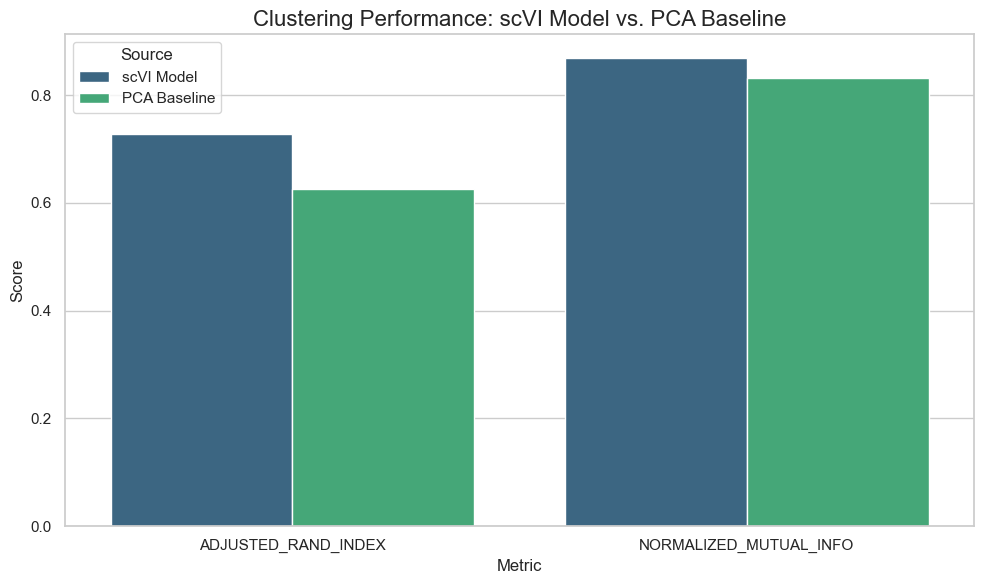

In [18]:
all_results = {}


# 1. Initialize the task
clustering_task = ClusteringTask()

# 2. Define the inputs for the task
clustering_task_input = ClusteringTaskInput(
    obs=dataset.adata.obs,
    input_labels=dataset.labels,
)

# 3. Run the task on your model's output
clustering_results = clustering_task.run(
    cell_representation=model_output,
    task_input=clustering_task_input,
)

# 4. Compute and run the baseline for comparison
expression_data = dataset.adata.X
clustering_baseline = clustering_task.compute_baseline(expression_data)
clustering_baseline_results = clustering_task.run(
    cell_representation=clustering_baseline,
    task_input=clustering_task_input,
)

# Store results for downstream use
all_results["clustering"] = {
    "model": [r.model_dump() for r in clustering_results],
    "baseline": [r.model_dump() for r in clustering_baseline_results],
}

# Prepare DataFrame for plotting
df_clustering_model = pd.DataFrame(all_results["clustering"]["model"])
df_clustering_baseline = pd.DataFrame(all_results["clustering"]["baseline"])
df_clustering_model["source"] = "scVI Model"
df_clustering_baseline["source"] = "PCA Baseline"
df_clustering = pd.concat([df_clustering_model, df_clustering_baseline])
df_clustering["metric_name"] = df_clustering["metric_type"].apply(lambda x: x.name)

print(df_clustering)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_clustering, x="metric_name", y="value", hue="source", palette="viridis"
)
plt.title("Clustering Performance: scVI Model vs. PCA Baseline", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Source")
plt.tight_layout()
plt.show()

### Step 5: Run Embedding Tasks

                   metric_type     value params        source  \
0  MetricType.SILHOUETTE_SCORE  0.627913     {}    scVI Model   
0  MetricType.SILHOUETTE_SCORE  0.650182     {}  PCA Baseline   

        metric_name  
0  SILHOUETTE_SCORE  
0  SILHOUETTE_SCORE  


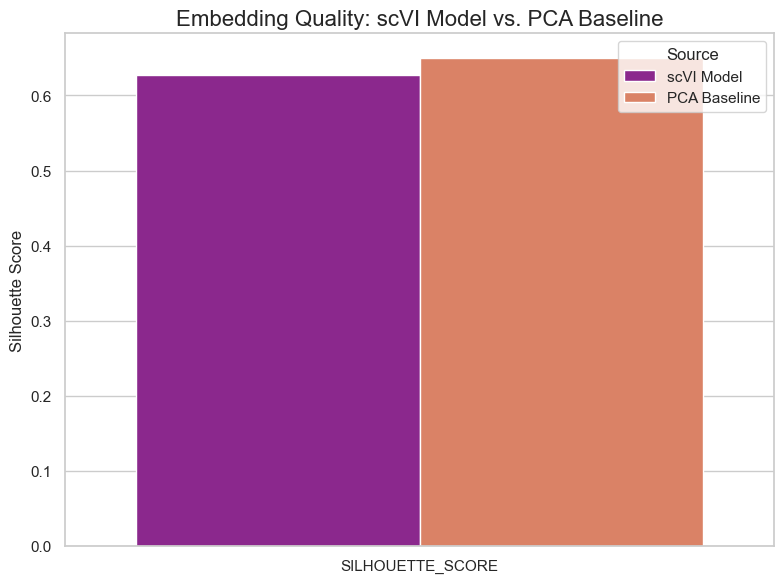

In [19]:
all_results = {}
# Get raw expression data for baseline computation
expression_data = dataset.adata.X

# --- Run Embedding Task ---
embedding_task = EmbeddingTask()
embedding_task_input = EmbeddingTaskInput(input_labels=dataset.labels)
embedding_results_model = embedding_task.run(model_output, embedding_task_input)
embedding_baseline = embedding_task.compute_baseline(expression_data)
embedding_results_baseline = embedding_task.run(
    embedding_baseline, embedding_task_input
)

# Store results
all_results["embedding"] = {
    "model": [r.model_dump() for r in embedding_results_model],
    "baseline": [r.model_dump() for r in embedding_results_baseline],
}

# Visualize Embedding Results
df_embedding_model = pd.DataFrame(all_results["embedding"]["model"])
df_embedding_baseline = pd.DataFrame(all_results["embedding"]["baseline"])
df_embedding_model["source"] = "scVI Model"
df_embedding_baseline["source"] = "PCA Baseline"
df_embedding = pd.concat([df_embedding_model, df_embedding_baseline])
df_embedding["metric_name"] = df_embedding["metric_type"].apply(lambda x: x.name)
print(df_embedding)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=df_embedding, x="metric_name", y="value", hue="source", palette="plasma"
)
plt.title("Embedding Quality: scVI Model vs. PCA Baseline", fontsize=16)
plt.ylabel("Silhouette Score", fontsize=12)
plt.xlabel("")
plt.legend(title="Source")
plt.tight_layout()
plt.show()

### Step 5: Run Label Prediction Tasks

INFO:czbenchmarks.tasks.label_prediction:Starting prediction task for labels
INFO:czbenchmarks.tasks.label_prediction:Initial data shape: (2044, 50), labels shape: (2044,)
INFO:czbenchmarks.tasks.utils:Label composition (cell_type):
INFO:czbenchmarks.tasks.utils:Total classes before filtering: 14
INFO:czbenchmarks.tasks.utils:Total classes after filtering (min_class_size=10): 13
INFO:czbenchmarks.tasks.label_prediction:After filtering: (2043, 50) samples remaining
INFO:czbenchmarks.tasks.label_prediction:Found 13 classes, using macro averaging for metrics
INFO:czbenchmarks.tasks.label_prediction:Using 5-fold cross validation with random_seed 42
INFO:czbenchmarks.tasks.label_prediction:Created classifiers: ['lr', 'knn', 'rf']
INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for lr...
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 i

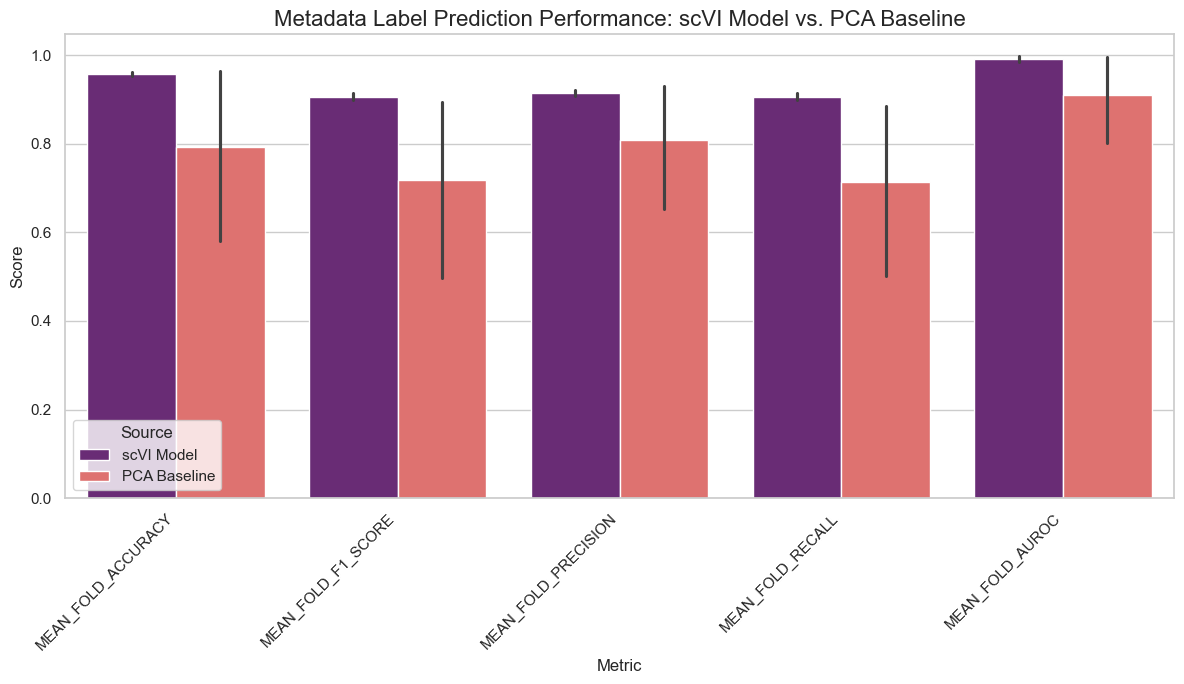

In [20]:
all_results = {}
# --- Run Prediction Task ---
# Run prediction task for model and baseline
prediction_task = MetadataLabelPredictionTask()
prediction_task_input = MetadataLabelPredictionTaskInput(labels=dataset.labels)
prediction_results_model = prediction_task.run(model_output, prediction_task_input)
prediction_baseline = prediction_task.compute_baseline(expression_data)
prediction_results_baseline = prediction_task.run(
    prediction_baseline, prediction_task_input
)

# Store results
all_results["prediction"] = {
    "model": [r.model_dump() for r in prediction_results_model],
    "baseline": [r.model_dump() for r in prediction_results_baseline],
}

# Visualize Prediction Results
df_pred_model = pd.DataFrame(all_results["prediction"]["model"])
df_pred_baseline = pd.DataFrame(all_results["prediction"]["baseline"])
df_pred_model["source"] = "scVI Model"
df_pred_baseline["source"] = "PCA Baseline"
df_pred = pd.concat([df_pred_model, df_pred_baseline])
df_pred["metric_name"] = df_pred["metric_type"].apply(lambda x: x.name)
df_pred["classifier"] = df_pred["params"].apply(
    lambda p: p.get("classifier", "Overall")
)


plt.figure(figsize=(12, 7))
sns.barplot(data=df_pred, x="metric_name", y="value", hue="source", palette="magma")
plt.title(
    "Metadata Label Prediction Performance: scVI Model vs. PCA Baseline", fontsize=16
)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Source")
plt.tight_layout()
plt.show()